# preprocessing

In [119]:
!rm -rf TabularDS  # Remove the existing directory
!git clone https://github.com/ItamarBerger/TabularDS


Cloning into 'TabularDS'...
remote: Enumerating objects: 706, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 706 (delta 7), reused 14 (delta 7), pack-reused 682 (from 1)
Receiving objects: 100% (706/706), 48.41 MiB | 17.26 MiB/s, done.
Resolving deltas: 100% (307/307), done.
Updating files: 100% (46/46), done.


In [117]:
import sys
import os
import sys

os.listdir('/content/TabularDS/final_project')
sys.path.append('/content/TabularDS/final_project/code')

from utils.rules_mining import *
from utils.clustering import *

# 1. MovieLens 20M dataset

In [81]:
import pandas as pd
transactions = pd.read_csv('/content/TabularDS/final_project/data/movies_with_clusters.csv')
min_support = 0.18
original_min_support = min_support

# take a smaller sample of given dataset, reducing time & space complexity
transactions = transactions[0:20000]
transactions.head()

,Toy Story (1995),Jumanji (1995),Heat (1995),GoldenEye (1995),"American President, The (1995)",Casino (1995),Sense and Sensibility (1995),Ace Ventura: When Nature Calls (1995),Get Shorty (1995),Leaving Las Vegas (1995),...,Kill Bill: Vol. 1 (2003),"Lord of the Rings: The Return of the King, The (2003)",Eternal Sunshine of the Spotless Mind (2004),Kill Bill: Vol. 2 (2004),Shrek 2 (2004),Spider-Man 2 (2004),"Incredibles, The (2004)",Sin City (2005),Batman Begins (2005),"Dark Knight, The (2008)"
0,0,1,0,0,0,0,0,0,0,0,...,0,1,0,1,0,1,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## I. Applying Classic Apriori for rule associasion mining

In [82]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth, association_rules


frequent_itemsets = fpgrowth(transactions, min_support=min_support, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


# Baseline apriori results

In [83]:
if not rules.empty:
  print(f"number of rules is: {len(rules)}")
  print(rules[0:3])

number of rules is: 3176
                          antecedents                         consequents  \
0  (Silence of the Lambs, The (1991))               (Pulp Fiction (1994))   
1               (Pulp Fiction (1994))  (Silence of the Lambs, The (1991))   
2               (Forrest Gump (1994))  (Silence of the Lambs, The (1991))   

   antecedent support  consequent support  support  confidence      lift  \
0             0.46705             0.50005  0.35420    0.758377  1.516602   
1             0.50005             0.46705  0.35420    0.708329  1.516602   
2             0.49420             0.46705  0.33175    0.671287  1.437291   

   representativity  leverage  conviction  zhangs_metric   jaccard  certainty  \
0               1.0  0.120652    2.069133       0.639143  0.577908   0.516706   
1               1.0  0.120652    1.827231       0.681331  0.577908   0.452724   
2               1.0  0.100934    1.621323       0.601516  0.527006   0.383220   

   kulczynski  
0    0.733353  
1   

In [84]:
print_basic_metrics(rules)
# Store the rules and itemsets for later use
original_rules = rules
original_itemsets = frequent_itemsets



Metrics: Support average: 0.2009, Confidence average: 0.6255, Lift average: 1.8707


## Visualize top rules
### (sorted by lift)

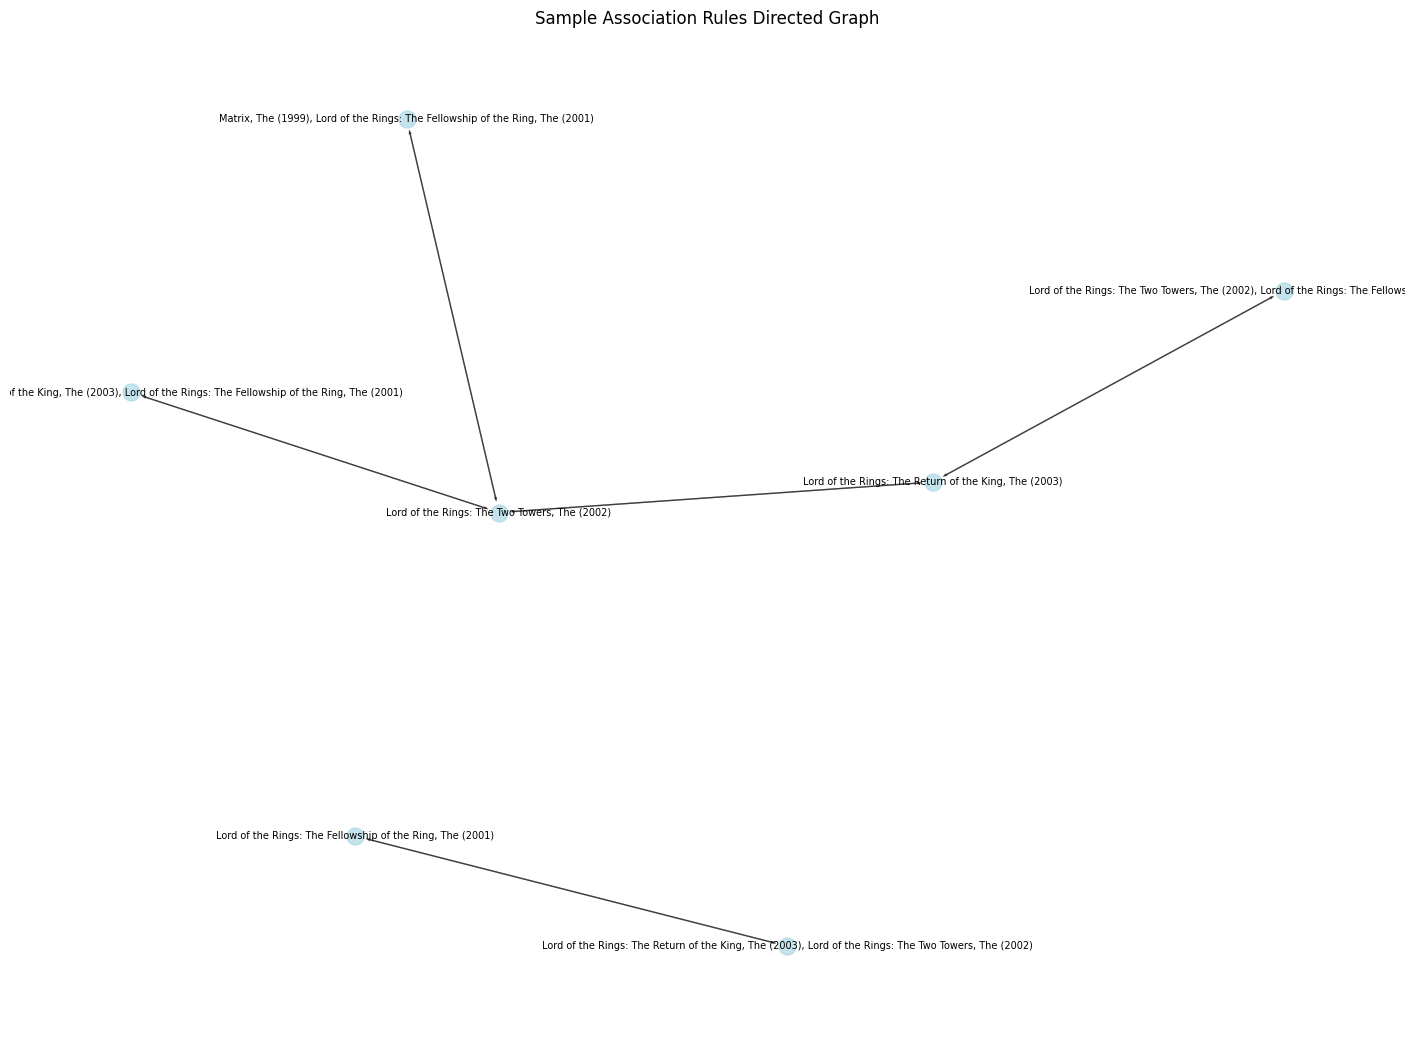

In [85]:
plot_topk_rules_in_graph(rules, frequent_itemsets)

max lift value is 3.7135
max confidence value is 0.9567


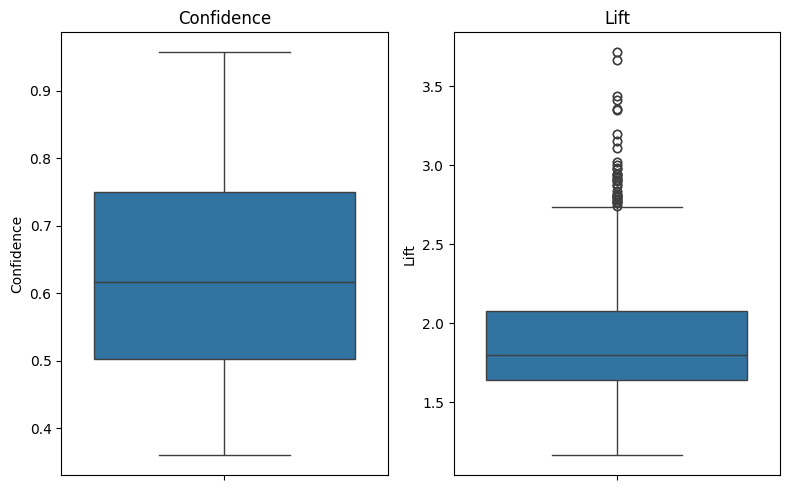

In [86]:
plot_metrics_boxplots(rules)

# Cluster items + Apriori


In [87]:
num_clusters = 50
add_cluster_users_col(num_clusters,transactions)
df = transactions


df = filter_valid_clusters_by_size(df)

/content/TabularDS/final_project/code/utils/clustering.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_percentages.index, y=cluster_percentages.values, palette='viridis')


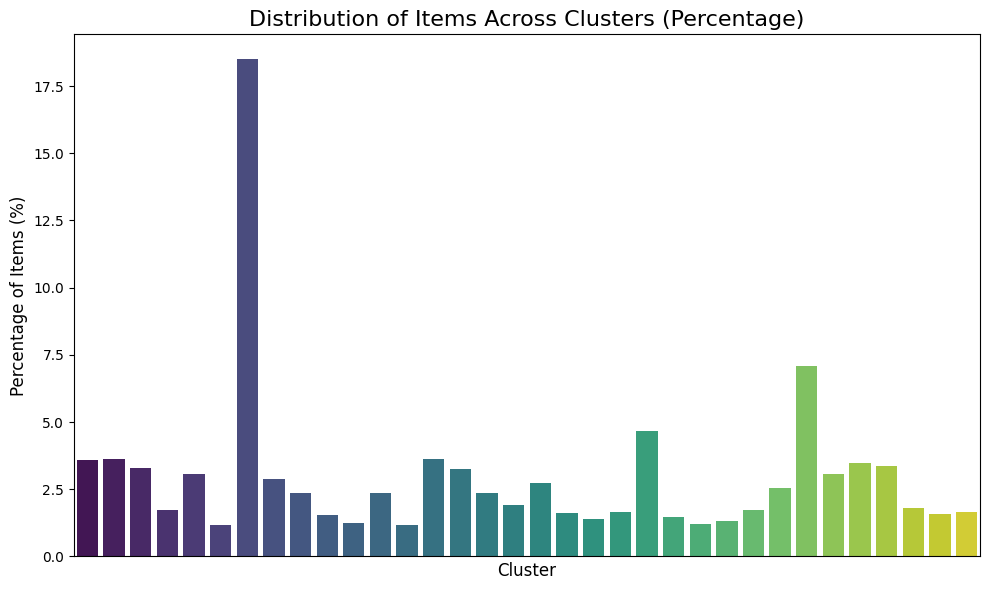

In [88]:
plot_cluster_distribution(df)

In [89]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mlxtend.frequent_patterns import fpgrowth


def process_cluster(cluster_id, df, min_support):
    print(f"\nProcessing Cluster {cluster_id}...")

    # Extract transactions of the current cluster
    cluster_data = df[df['Cluster'] == cluster_id].drop(columns=['Cluster'])

    # Calculate and print sparsity for this cluster
    print(f"size of Cluster is: {len(cluster_data)}")

    # Run FPGrowth
    frequent_itemsets = fpgrowth(cluster_data, min_support=min_support, use_colnames=True)

    if frequent_itemsets.empty:
        print(f"No frequent itemsets found in Cluster {cluster_id}.")
        return None

    # Generate association rules
    rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

    print(f"Cluster {cluster_id}: {len(rules)} rules generated.")
    return cluster_id, {"frequent_itemsets": frequent_itemsets, "rules": rules}

def find_clusters_rules(df, min_support):
    cluster_results = {}
    for cluster_id in sorted(df['Cluster'].unique()):
        cluster_data = df[df['Cluster'] == cluster_id].drop(columns=['Cluster'])
        # Calculate and filter clusters with less sparsity than desired.
        if df['Cluster'].value_counts()[cluster_id] < 0.025 * len(transactions):
            cluster_results[cluster_id] = cluster_id, {"frequent_itemsets": None, "rules": None}
            continue
        cluster_results[cluster_id] = process_cluster(cluster_id, df, min_support)
    return cluster_results



In [90]:
cluster_results = find_clusters_rules(transactions, min_support=0.5)



Processing Cluster 0...
size of Cluster is: 627
Cluster 0: 0 rules generated.

Processing Cluster 2...
size of Cluster is: 631
Cluster 2: 14 rules generated.

Processing Cluster 4...
size of Cluster is: 577
Cluster 4: 10 rules generated.

Processing Cluster 6...
size of Cluster is: 534
Cluster 6: 8 rules generated.

Processing Cluster 8...
size of Cluster is: 3226
No frequent itemsets found in Cluster 8.

Processing Cluster 9...


/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in wors

size of Cluster is: 504
Cluster 9: 1178 rules generated.

Processing Cluster 15...
size of Cluster is: 630


/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


Cluster 15: 8076 rules generated.

Processing Cluster 16...
size of Cluster is: 566
Cluster 16: 8 rules generated.

Processing Cluster 29...
size of Cluster is: 813
Cluster 29: 12 rules generated.

Processing Cluster 40...
size of Cluster is: 1236
Cluster 40: 0 rules generated.

Processing Cluster 43...
size of Cluster is: 537


/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in wors

Cluster 43: 196 rules generated.

Processing Cluster 44...
size of Cluster is: 603
Cluster 44: 0 rules generated.

Processing Cluster 45...
size of Cluster is: 585
Cluster 45: 16 rules generated.


/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [91]:
import pandas as pd


def aggregate_all_rules(cluster_results, transactions, original_min_support):
    # Initialize an empty list to store all the rules
    all_rules = []

    # Loop through all cluster results and combine the rules
    for id, cluster_data in cluster_results.items():
        if cluster_data is None:
            continue
        rules = cluster_data[1]["rules"]
        if rules is None or rules.empty:
            continue
        rules['Cluster'] = id
        all_rules.append(rules)

    # Concatenate all the rules into a single DataFrame
    all_rules_df = pd.concat(all_rules, ignore_index=True)
    # Remove duplicates if needed
    all_rules_df = all_rules_df.drop_duplicates(subset=['antecedents', 'consequents'])



    # Now calculate the global metrics for all rules in one go
    all_rules_df['global_antecedent_support'] = all_rules_df['antecedents'].apply(
        lambda x: calculate_global_support(set(x), transactions)
    )

    all_rules_df['global_consequent_support'] = all_rules_df['consequents'].apply(
        lambda x: calculate_global_support(set(x), transactions)
    )

    # Calculate global rule support (for antecedent + consequent together)
    all_rules_df['global_rule_support'] = all_rules_df.apply(
        lambda row: calculate_global_support(set(row['antecedents']).union(set(row['consequents'])) , transactions),
        axis=1
    )

    # Calculate global confidence
    all_rules_df['global_confidence'] = all_rules_df['global_rule_support'] / all_rules_df['global_antecedent_support']

    # Calculate global lift
    all_rules_df['global_lift'] = all_rules_df['global_confidence'] / all_rules_df['global_consequent_support']


    comparable_rules = all_rules_df[all_rules_df['global_rule_support'] >= original_min_support]
    print(f"number of rules shared with baseline approach: {len(comparable_rules)}")
    print(f"ratio of shared rules: {len(comparable_rules) / max(len(all_rules_df), 1)}")


    return all_rules_df



In [92]:
all_rules_df = aggregate_all_rules(cluster_results, transactions, original_min_support)

number of rules shared with baseline approach: 228
ratio of shared rules: 0.02404556000843704


In [93]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_rules_comparison(all_rules_df, original_rules=None):  # Added original_rules as an optional parameter
    # Ensure overall_metrics is properly initialized
    overall_metrics = {
        'Support': {},
        'Confidence': {},
        'Lift': {}
    }

    # Group the rules by cluster and calculate the mean for each metric
    cluster_metrics_df = all_rules_df.groupby('Cluster')[['global_rule_support', 'global_confidence', 'global_lift']].mean().reset_index()

    # Compute stats for all clusters
    if not all_rules_df.empty:
        avg_support_all_clusters = all_rules_df['global_rule_support'].mean()
        min_support_all_clusters = all_rules_df['global_rule_support'].min()
        max_support_all_clusters = all_rules_df['global_rule_support'].max()

        avg_confidence_all_clusters = all_rules_df['global_confidence'].mean()
        min_confidence_all_clusters = all_rules_df['global_confidence'].min()
        max_confidence_all_clusters = all_rules_df['global_confidence'].max()

        avg_lift_all_clusters = all_rules_df['global_lift'].mean()
        min_lift_all_clusters = all_rules_df['global_lift'].min()
        max_lift_all_clusters = all_rules_df['global_lift'].max()

        total_rules = len(all_rules_df)
    else:
        avg_support_all_clusters = min_support_all_clusters = max_support_all_clusters = 0
        avg_confidence_all_clusters = min_confidence_all_clusters = max_confidence_all_clusters = 0
        avg_lift_all_clusters = min_lift_all_clusters = max_lift_all_clusters = 0
        total_rules = 0

    # Add overall metrics for all clusters
    overall_metrics['Support']['All Clusters'] = avg_support_all_clusters
    overall_metrics['Confidence']['All Clusters'] = avg_confidence_all_clusters
    overall_metrics['Lift']['All Clusters'] = avg_lift_all_clusters

    # Compute metrics for original rules
    if original_rules is not None and not original_rules.empty:
        avg_support_original = original_rules["support"].mean()
        min_support_original = original_rules["support"].min()
        max_support_original = original_rules["support"].max()

        avg_confidence_original = original_rules["confidence"].mean()
        min_confidence_original = original_rules["confidence"].min()
        max_confidence_original = original_rules["confidence"].max()

        avg_lift_original = original_rules["lift"].mean()
        min_lift_original = original_rules["lift"].min()
        max_lift_original = original_rules["lift"].max()

        total_original_rules = len(original_rules)
    else:
        avg_support_original = min_support_original = max_support_original = 0
        avg_confidence_original = min_confidence_original = max_confidence_original = 0
        avg_lift_original = min_lift_original = max_lift_original = 0
        total_original_rules = 0

    # Add original rules metrics to overall metrics
    overall_metrics['Support']['Original Rules'] = avg_support_original
    overall_metrics['Confidence']['Original Rules'] = avg_confidence_original
    overall_metrics['Lift']['Original Rules'] = avg_lift_original

    # Print Markdown tables
    print(f"**Number of distinct rules: {total_original_rules}**\n")

    print(f"**Number of rules: {total_rules}**\n")
    print("| Metric       | Avg          | Min          | Max          |")
    print("|--------------|--------------|--------------|--------------|")
    print(f"| Support      | {avg_support_all_clusters:.7f} | {min_support_all_clusters:.7f} | {max_support_all_clusters:.7f} |")
    print(f"| Confidence   | {avg_confidence_all_clusters:.7f} | {min_confidence_all_clusters:.7f} | {max_confidence_all_clusters:.7f} |")
    print(f"| Lift         | {avg_lift_all_clusters:.7f} | {min_lift_all_clusters:.7f} | {max_lift_all_clusters:.7f} |")
    print("\n")

    if original_rules is not None and not original_rules.empty:
        print("| Metric       | Avg          | Min          | Max          |")
        print("|--------------|--------------|--------------|--------------|")
        print(f"| Support      | {avg_support_original:.7f} | {min_support_original:.7f} | {max_support_original:.7f} |")
        print(f"| Confidence   | {avg_confidence_original:.7f} | {min_confidence_original:.7f} | {max_confidence_original:.7f} |")
        print(f"| Lift         | {avg_lift_original:.7f} | {min_lift_original:.7f} | {max_lift_original:.7f} |")
        print("\n")
    else: print ("original rules set is empty")

    # Prepare the data for plotting each metric separately
    metrics = ['global_rule_support', 'global_confidence', 'global_lift']
    metric_mapping = {'global_rule_support': 'Support', 'global_confidence': 'Confidence', 'global_lift': 'Lift'}

    # Create individual plots for each metric
    for metric in metrics:
        fig, ax = plt.subplots(figsize=(12, 6))

        # Plot the metrics for each cluster
        sns.barplot(x='Cluster', y=metric, data=cluster_metrics_df, color='lightgreen', label=f'{metric_mapping[metric]} per Cluster', ax=ax)

        # Plot overall metrics (all clusters and original rules)
        ax.axhline(y=overall_metrics[metric_mapping[metric]]['All Clusters'], color='blue', linestyle='--', label=f'{metric_mapping[metric]} (All Clusters)')
        ax.axhline(y=overall_metrics[metric_mapping[metric]]['Original Rules'], color='darkblue', linestyle=':', label=f'{metric_mapping[metric]} (Original Rules)')

        # Add labels and title
        ax.set_title(f'{metric_mapping[metric]} Comparison for Clusters and Baseline Rules', fontsize=16)
        ax.set_xlabel('Cluster', fontsize=12)
        ax.set_ylabel(f'{metric_mapping[metric]} Value', fontsize=12)
        ax.legend(title='Metric Type')

        # Show the plot
        plt.tight_layout()
        plt.savefig(f"music_{metric_mapping[metric].lower()}_comparison.png")
        plt.show()



**Number of rules: 9482**

| Metric       | Avg          | Min          | Max          |
|--------------|--------------|--------------|--------------|
| Support      | 0.0758427 | 0.0354000 | 0.3486500 |
| Confidence   | 0.5502363 | 0.1025237 | 0.9819915 |
| Lift         | 3.8184838 | 1.2140240 | 7.6053746 |


original rules set is empty


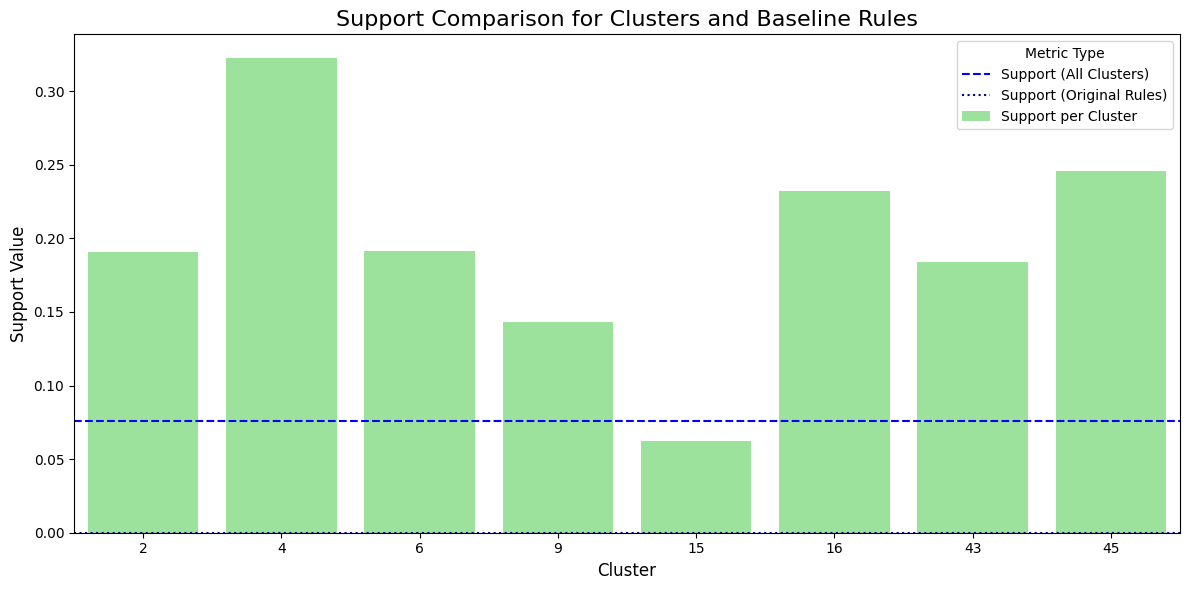

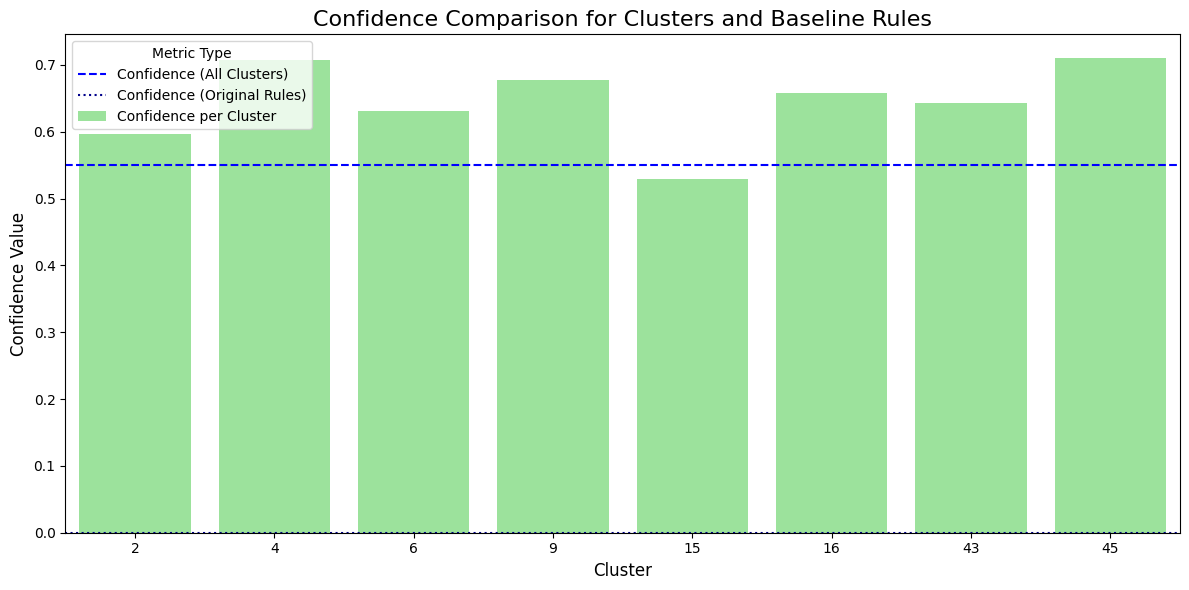

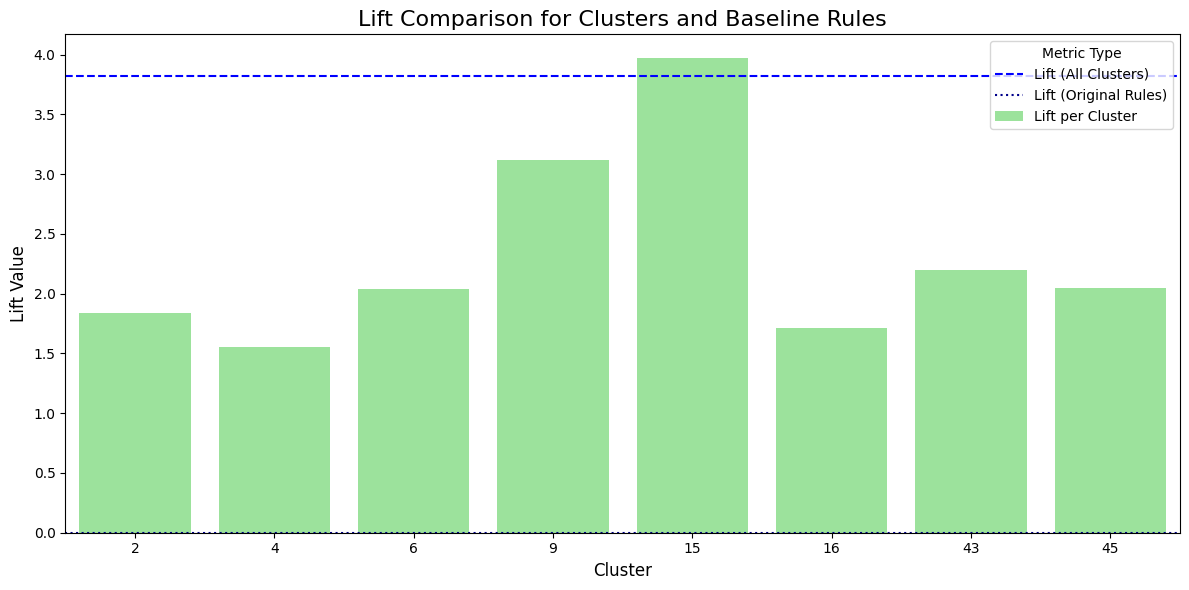

In [94]:
plot_rules_comparison(all_rules_df, original_rules)


# 2. Online Retail Datsaset

In [95]:
transactions = pd.read_csv("/content/TabularDS/final_project/data/online_retail_transactional.csv")
transactions.head()

,10 COLOUR SPACEBOY PEN,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,12 PENCILS TALL TUBE POSY,12 PENCILS TALL TUBE RED RETROSPOT,12 PENCILS TALL TUBE SKULLS,12 PENCILS TALL TUBE WOODLAND,15CM CHRISTMAS GLASS BALL 20 LIGHTS,...,WORLD WAR 2 GLIDERS ASSTD DESIGNS,WRAP 50'S CHRISTMAS,WRAP ALPHABET DESIGN,WRAP ENGLISH ROSE,YOU'RE CONFUSING ME METAL SIGN,ZINC FOLKART SLEIGH BELLS,ZINC HERB GARDEN CONTAINER,ZINC METAL HEART DECORATION,ZINC T-LIGHT HOLDER STARS SMALL,ZINC WILLIE WINKIE CANDLE STICK
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [96]:
import pandas as pd
min_support = 0.05
original_min_support = min_support

## I. Applying Classic Apriori for rule associasion mining


In [97]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth, association_rules


frequent_itemsets = fpgrowth(transactions, min_support=min_support, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)



/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [98]:

original_rules = rules
original_itemsets = frequent_itemsets

In [99]:
if not rules.empty:
  print(f"number of rules is: {len(rules)}")
  print(rules[0:3])

number of rules is: 240
                          antecedents                         consequents  \
0  (ROSES REGENCY TEACUP AND SAUCER )          (REGENCY CAKESTAND 3 TIER)   
1          (REGENCY CAKESTAND 3 TIER)  (ROSES REGENCY TEACUP AND SAUCER )   
2   (PACK OF 72 RETROSPOT CAKE CASES)       (60 TEATIME FAIRY CAKE CASES)   

   antecedent support  consequent support   support  confidence      lift  \
0            0.099535            0.206512  0.075581    0.759346  3.677012   
1            0.206512            0.099535  0.075581    0.365991  3.677012   
2            0.148140            0.096744  0.063023    0.425432  4.397491   

   representativity  leverage  conviction  zhangs_metric   jaccard  certainty  \
0               1.0  0.055026    3.297214       0.808516  0.327952   0.696714   
1               1.0  0.055026    1.420272       0.917518  0.327952   0.295909   
2               1.0  0.048692    1.572060       0.906953  0.346547   0.363892   

   kulczynski  
0    0.562668  
1

In [100]:
import numpy as np

print_basic_metrics(rules)
# Store the rules and itemsets for later use
original_rules = rules
original_itemsets = frequent_itemsets



Metrics: Support average: 0.0580, Confidence average: 0.5710, Lift average: 5.6758


## II. Cluster items + Apriori


In [101]:
from sklearn.cluster import KMeans

num_clusters = 40
add_cluster_users_col(num_clusters,transactions)
df = transactions

silhouette score of clustering is: 0.22077753165348726


/content/TabularDS/final_project/code/utils/clustering.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_percentages.index, y=cluster_percentages.values, palette='viridis')


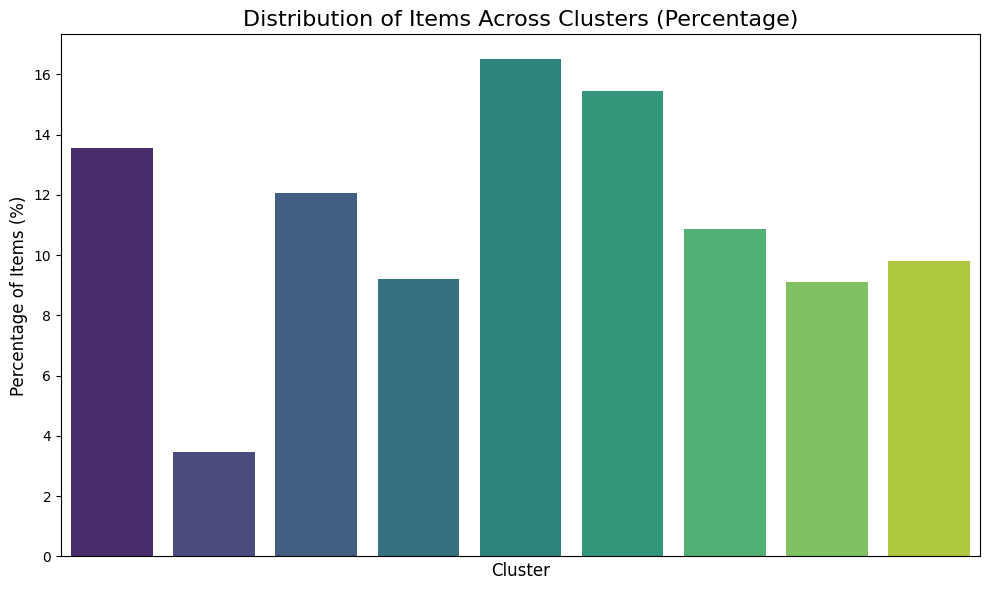

In [102]:
from sklearn.metrics import silhouette_score

score=silhouette_score(df, df['Cluster'])
print(f"silhouette score of clustering is: {score}")



# filter extreme clusters by size. (containing less than 1% or more than 30% of the transactions)
df = filter_valid_clusters_by_size(df)

plot_cluster_distribution(df)


In [103]:
cluster_results = find_clusters_rules(transactions, min_support=0.4)


Processing Cluster 2...
size of Cluster is: 247
Cluster 2: 0 rules generated.

Processing Cluster 7...
size of Cluster is: 220
Cluster 7: 2 rules generated.

Processing Cluster 10...


/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


size of Cluster is: 168
Cluster 10: 24 rules generated.

Processing Cluster 12...
size of Cluster is: 301
Cluster 12: 0 rules generated.

Processing Cluster 13...
size of Cluster is: 282
Cluster 13: 0 rules generated.

Processing Cluster 16...
size of Cluster is: 198
Cluster 16: 0 rules generated.

Processing Cluster 21...
size of Cluster is: 166


/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in wors

Cluster 21: 246 rules generated.

Processing Cluster 28...
size of Cluster is: 2274
No frequent itemsets found in Cluster 28.

Processing Cluster 30...
size of Cluster is: 179


/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


Cluster 30: 1580 rules generated.


In [104]:
original_min_support = 0.05
all_rules_df = aggregate_all_rules(cluster_results, transactions, original_min_support)


number of rules shared with baseline approach: 140
ratio of shared rules: 0.0755939524838013


In [105]:
original_min_support = 0.05
all_rules_df = aggregate_all_rules(cluster_results, transactions, original_min_support)


KeyboardInterrupt: 

In [ ]:
plot_rules_comparison(all_rules_df, original_rules)

# Users & Musical Artists Dataset

In [106]:
import pandas as pd
transactions = pd.read_csv("/content/TabularDS/final_project/data/user_artists_transactional.csv")
transactions.head()

,Marilyn Manson,Duran Duran,Kylie Minogue,Daft Punk,Goldfrapp,New Order,Coldplay,Madonna,Moby,Depeche Mode,...,Led Zeppelin,Ramones,Jay-Z,Avenged Sevenfold,Adele,KISS,Aerosmith,Robyn,Regina Spektor,Cansei de Ser Sexy
0,0,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [107]:
import pandas as pd
min_support = 0.1
original_min_support = min_support

In [108]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth, association_rules


frequent_itemsets = fpgrowth(transactions, min_support=min_support, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [109]:
if not rules.empty:
  print(f"number of rules is: {len(rules)}")
  print(rules[0:3])

number of rules is: 4458
        antecedents  consequents  antecedent support  consequent support  \
0       (Lady Gaga)    (Madonna)            0.334611            0.234940   
1         (Madonna)  (Lady Gaga)            0.234940            0.334611   
2  (Britney Spears)    (Madonna)            0.285871            0.234940   

   support  confidence      lift  representativity  leverage  conviction  \
0  0.16977    0.507365  2.159553               1.0  0.091157    1.552996   
1  0.16977    0.722611  2.159553               1.0  0.091157    2.398755   
2  0.16977    0.593870  2.527753               1.0  0.102608    1.883780   

   zhangs_metric   jaccard  certainty  kulczynski  
0       0.806959  0.424658   0.356083    0.614988  
1       0.701829  0.424658   0.583117    0.614988  
2       0.846334  0.483619   0.469153    0.658240  


In [110]:
import numpy as np

print_basic_metrics(rules)
# Store the rules and itemsets for later use
original_rules = rules
original_itemsets = frequent_itemsets


Metrics: Support average: 0.1160, Confidence average: 0.6657, Lift average: 3.6084


## II. Cluster items + Apriori


In [111]:
from sklearn.cluster import KMeans

num_clusters = 60
add_cluster_users_col(num_clusters, transactions)
df = transactions

silhouette score of clustering is: 0.15160561728112565


/content/TabularDS/final_project/code/utils/clustering.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_percentages.index, y=cluster_percentages.values, palette='viridis')


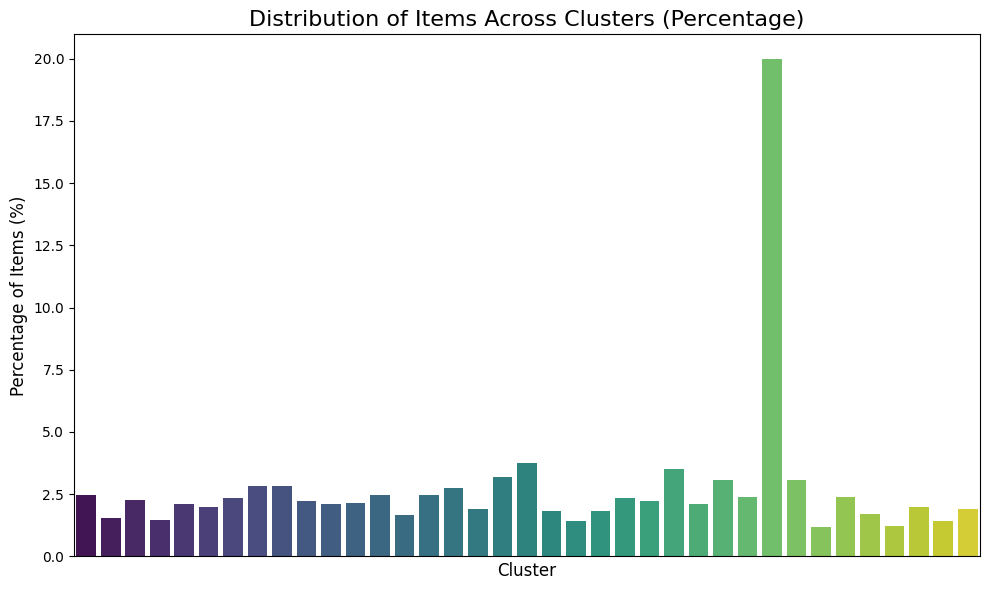

In [112]:
from sklearn.metrics import silhouette_score

score=silhouette_score(df, df['Cluster'])
print(f"silhouette score of clustering is: {score}")



# filter extreme clusters by size. (containing less than 1% or more than 30% of the transactions)
df = filter_valid_clusters_by_size(df)

plot_cluster_distribution(df)


In [113]:
cluster_results = find_clusters_rules(transactions, min_support=0.3)


Processing Cluster 15...
size of Cluster is: 46


/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


Cluster 15: 2102 rules generated.

Processing Cluster 16...
size of Cluster is: 46
Cluster 16: 6 rules generated.

Processing Cluster 27...
size of Cluster is: 52
Cluster 27: 22 rules generated.

Processing Cluster 28...
size of Cluster is: 61
Cluster 28: 6 rules generated.

Processing Cluster 41...
size of Cluster is: 57
Cluster 41: 4 rules generated.

Processing Cluster 44...
size of Cluster is: 50
Cluster 44: 42 rules generated.

Processing Cluster 48...
size of Cluster is: 325
No frequent itemsets found in Cluster 48.

Processing Cluster 49...
size of Cluster is: 50
Cluster 49: 60 rules generated.


/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in wors

In [114]:
original_min_support = 0.1
all_rules_df = aggregate_all_rules(cluster_results, transactions, original_min_support)


number of rules shared with baseline approach: 20
ratio of shared rules: 0.008920606601248885


**Number of rules: 2242**

| Metric       | Avg          | Min          | Max          |
|--------------|--------------|--------------|--------------|
| Support      | 0.0238546 | 0.0093100 | 0.2168675 |
| Confidence   | 0.3884072 | 0.0278232 | 1.0000000 |
| Lift         | 5.5031059 | 0.6973268 | 17.1993721 |


## Our Solution
**Number of distinct rules: 4458**

| Metric       | Avg          | Min          | Max          |
|--------------|--------------|--------------|--------------|
| Support      | 0.1159801 | 0.1002191 | 0.2387733 |
| Confidence   | 0.6656595 | 0.2995090 | 0.9947368 |
| Lift         | 3.6084335 | 1.6627986 | 5.0973262 |




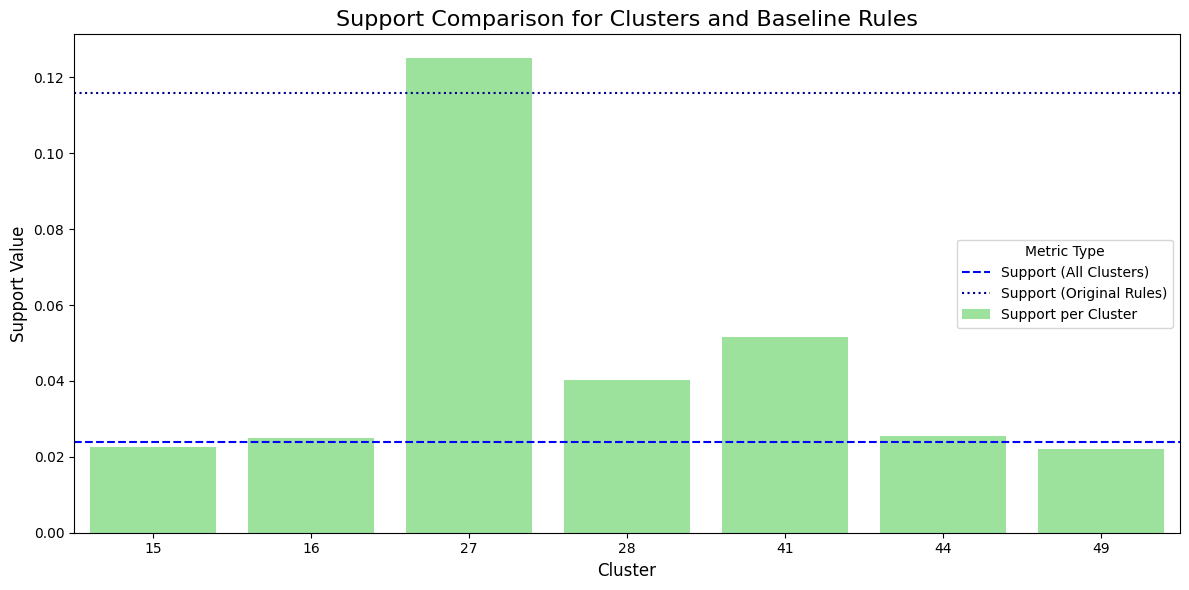

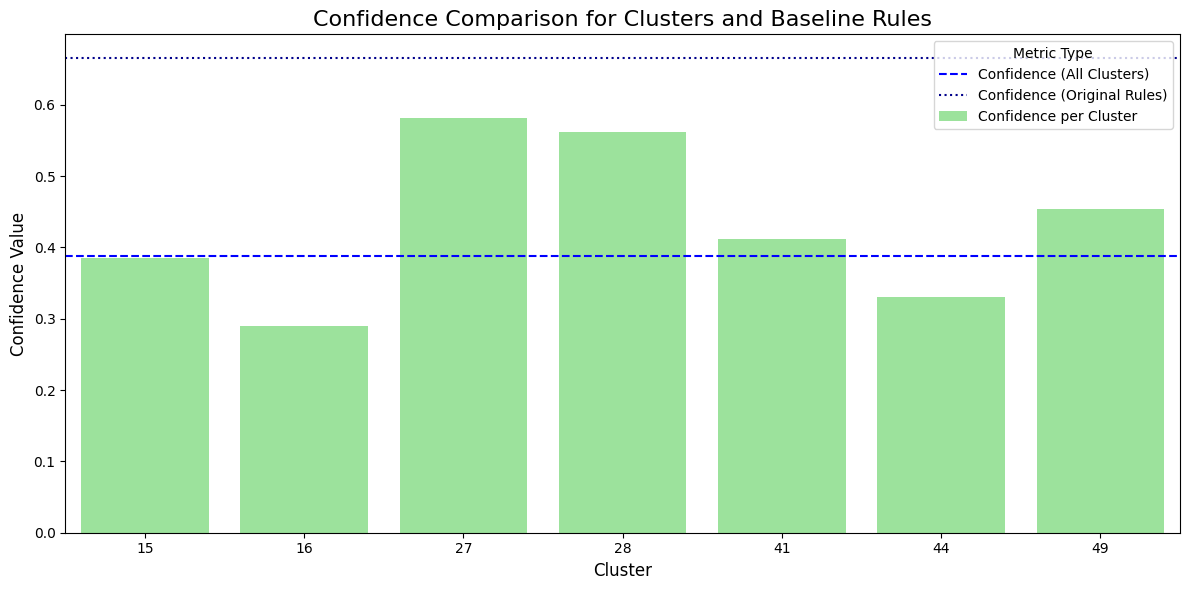

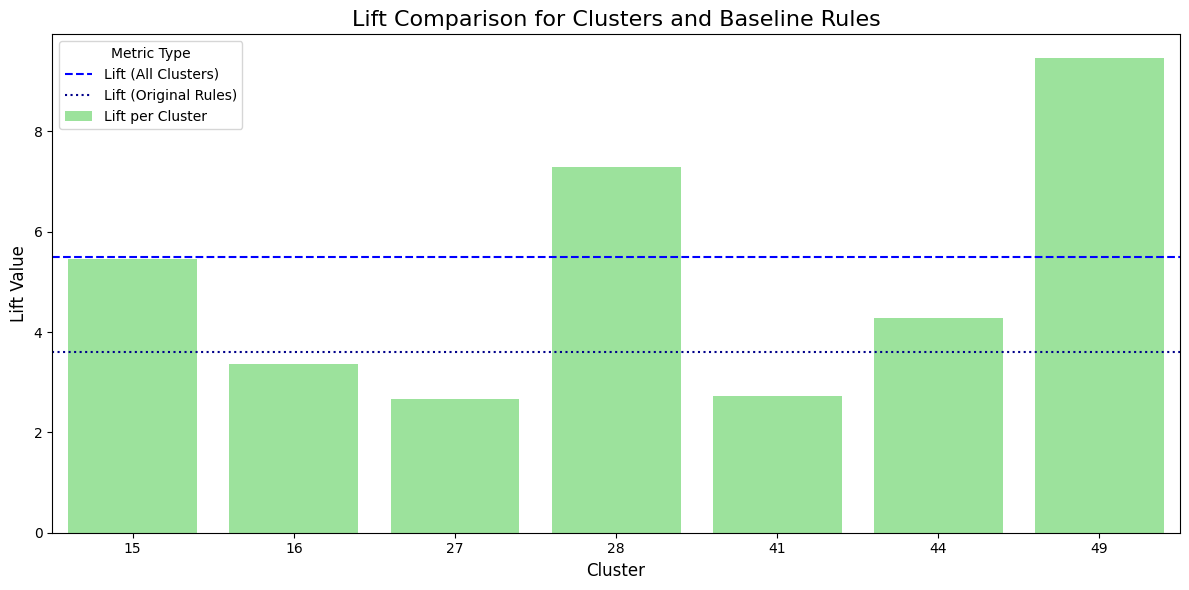

In [115]:
plot_rules_comparison(all_rules_df, original_rules)

# Netflix Prize dataset

In [121]:
transactions = pd.read_csv("/content/TabularDS/final_project/data/netflix_transactional.csv",skiprows=1,  # Skip the first row
    header=0)
transactions.head()

,Dinosaur Planet,Isle of Man TT 2004 Review,Character,Paula Abdul's Get Up & Dance,The Rise and Fall of ECW,Sick,8 Man,What the #$*! Do We Know!?,Class of Nuke 'Em High 2,Fighter,...,7 Seconds.1,Immortal Beloved.1,By Dawn's Early Light.1,Seeta Aur Geeta.1,Strange Relations.1,Chump Change.1,Clifford: Clifford Saves the Day! / Clifford's Fluffiest Friend Cleo.1,My Bloody Valentine.1,Inspector Morse 31: Death Is Now My Neighbour.1,Never Die Alone.1
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [126]:
import pandas as pd
min_support = 0.01
original_min_support = min_support

## I. Applying Classic Apriori for rule associasion mining


In [127]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth, association_rules


frequent_itemsets = fpgrowth(transactions, min_support=min_support, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)



/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [128]:

original_rules = rules
original_itemsets = frequent_itemsets

In [129]:
if not rules.empty:
  print(f"number of rules is: {len(rules)}")
  print(rules[0:3])

number of rules is: 112
                                        antecedents  \
0                                       (Character)   
1                                     (Character.1)   
2  (What the #$*! Do We Know!?.1, Immortal Beloved)   

                    consequents  antecedent support  consequent support  \
0                 (Character.1)            0.046644            0.046644   
1                   (Character)            0.046644            0.046644   
2  (What the #$*! Do We Know!?)            0.029048            0.345659   

    support  confidence       lift  representativity  leverage  conviction  \
0  0.046644         1.0  21.438867               1.0  0.044469         inf   
1  0.046644         1.0  21.438867               1.0  0.044469         inf   
2  0.029048         1.0   2.893025               1.0  0.019008         inf   

   zhangs_metric   jaccard  certainty  kulczynski  
0       1.000000  1.000000        1.0    1.000000  
1       1.000000  1.000000        1.0

In [130]:
import numpy as np

print_basic_metrics(rules)
# Store the rules and itemsets for later use
original_rules = rules
original_itemsets = frequent_itemsets



Metrics: Support average: 0.0330, Confidence average: 0.7132, Lift average: 21.4071


## II. Cluster items + Apriori


In [142]:
from sklearn.cluster import KMeans

num_clusters = 20
add_cluster_users_col(num_clusters, transactions)
df = transactions

/content/TabularDS/final_project/code/utils/clustering.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_percentages.index, y=cluster_percentages.values, palette='viridis')


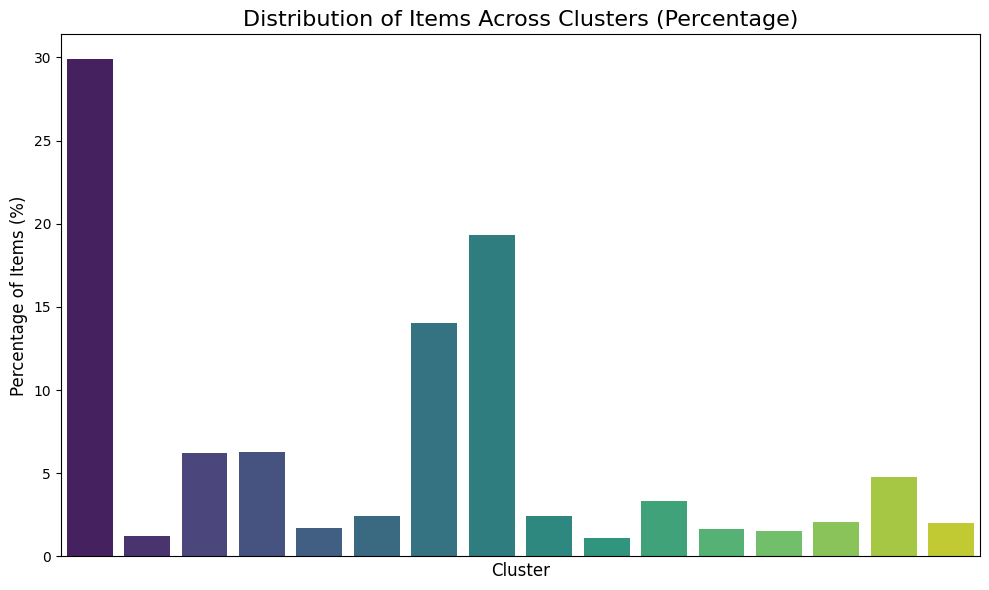

In [144]:
from sklearn.metrics import silhouette_score

# score=silhouette_score(df, df['Cluster'])
# print(f"silhouette score of clustering is: {score}")



# filter extreme clusters by size. (containing less than 1% or more than 30% of the transactions)
df = filter_valid_clusters_by_size(df)

plot_cluster_distribution(df)


In [145]:
cluster_results = find_clusters_rules(transactions, min_support=0.02)


Processing Cluster 0...
size of Cluster is: 12551
Cluster 0: 2 rules generated.

Processing Cluster 2...
size of Cluster is: 2600
Cluster 2: 6 rules generated.

Processing Cluster 4...
size of Cluster is: 2633


/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/association_rules.py:186: RuntimeWarning: invalid value encountered in divide
  cert_metric = np.where(certainty_denom == 0, 0, certainty_num / certainty_denom)
/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be dis

Cluster 4: 2 rules generated.

Processing Cluster 8...
size of Cluster is: 5881
Cluster 8: 2 rules generated.

Processing Cluster 9...
size of Cluster is: 8114
Cluster 9: 2 rules generated.

Processing Cluster 13...
size of Cluster is: 1392
Cluster 13: 606 rules generated.

Processing Cluster 17...
size of Cluster is: 2001
Cluster 17: 4 rules generated.


/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [146]:
original_min_support = 0.01
all_rules_df = aggregate_all_rules(cluster_results, transactions, original_min_support)


number of rules shared with baseline approach: 66
ratio of shared rules: 0.10714285714285714


**Number of rules: 616**

| Metric       | Avg          | Min          | Max          |
|--------------|--------------|--------------|--------------|
| Support      | 0.0060682 | 0.0010896 | 0.3456590 |
| Confidence   | 0.3343641 | 0.0031522 | 1.0000000 |
| Lift         | 37.0355164 | 0.1391973 | 917.7659574 |


## Our Solution
**Number of distinct rules: 112**

| Metric       | Avg          | Min          | Max          |
|--------------|--------------|--------------|--------------|
| Support      | 0.0330308 | 0.0108033 | 0.3456590 |
| Confidence   | 0.7132389 | 0.0434620 | 1.0000000 |
| Lift         | 21.4071420 | 2.8930248 | 92.5643777 |




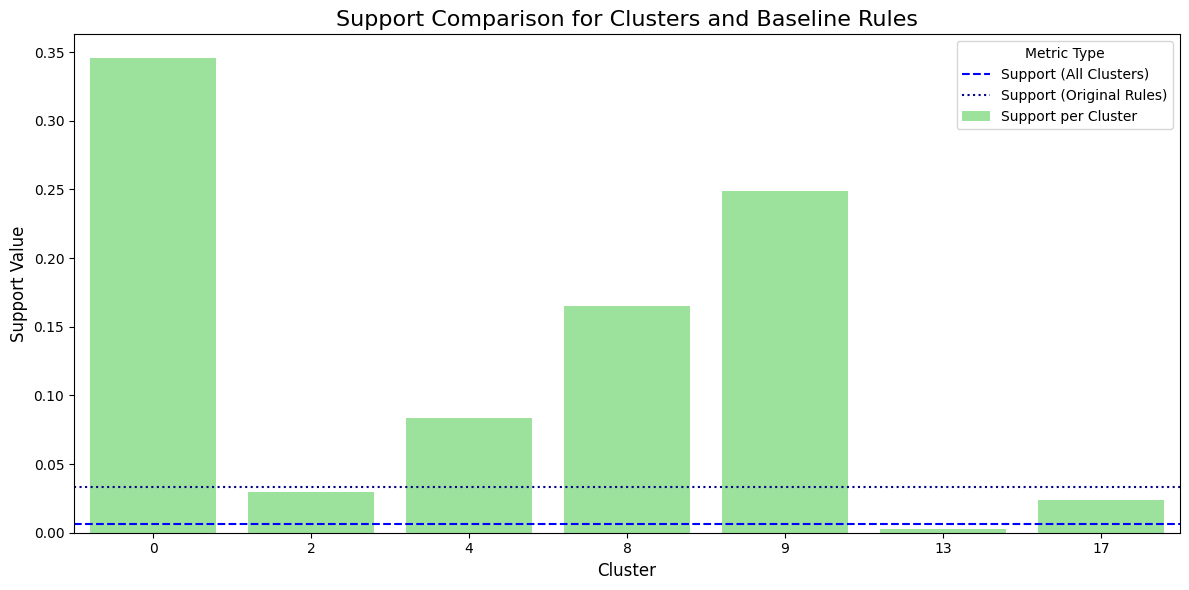

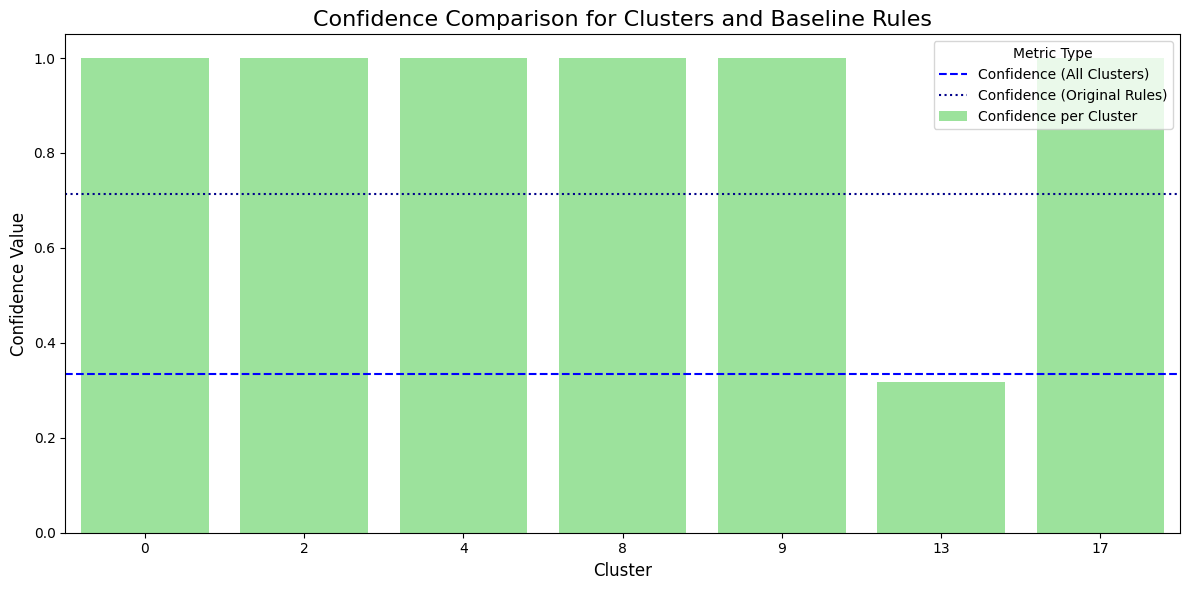

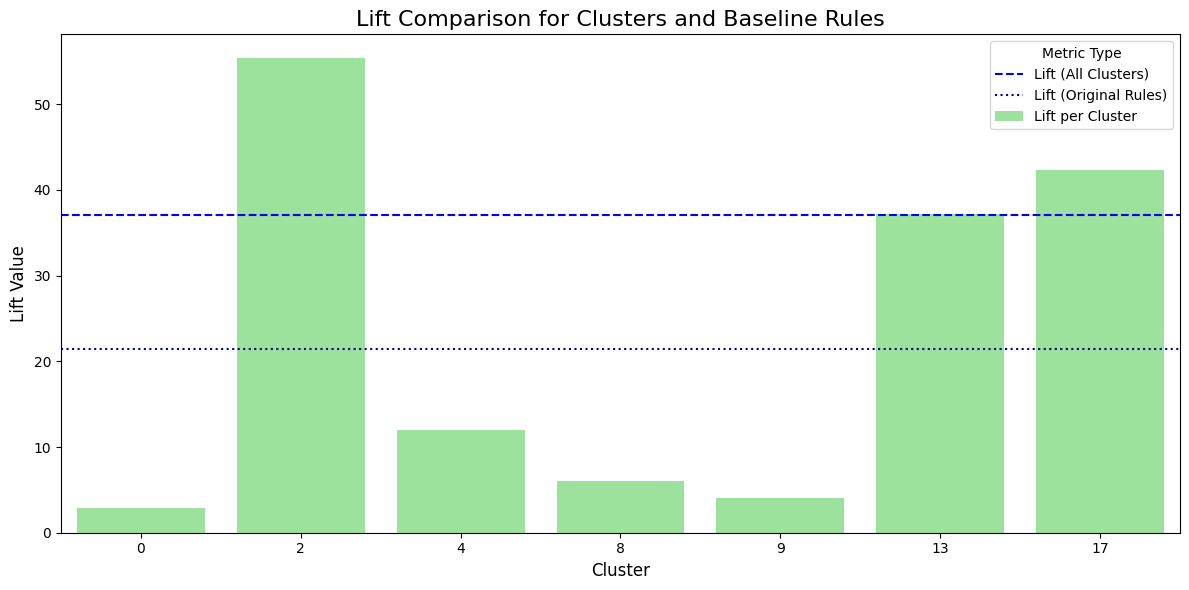

In [147]:
plot_rules_comparison(all_rules_df, original_rules)